# Exploration of C4b positive OLs and its associated genes

In [1]:
import scanpy as sc

In [2]:
ad = sc.read_h5ad('/Users/christoffer/work/karolinska/development/metamitoMicS/data/RREAE_5k_raw_only_integration_processed.h5ad')

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [50]:
# 1. Normalize counts per cell (CPM-like, to 1e4 total counts per cell by default)
sc.pp.normalize_total(ad, target_sum=1e4)

# 2. Log1p transform (natural log, log(x+1))
sc.pp.log1p(ad)

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


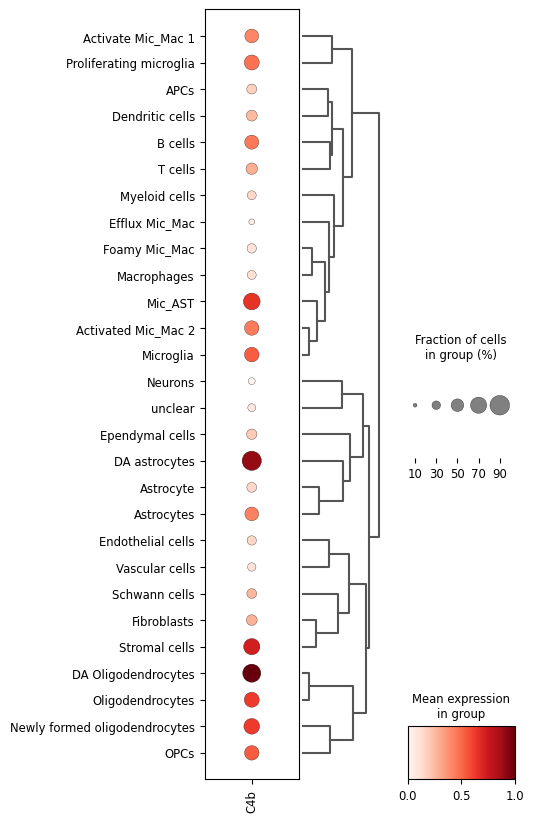

In [138]:
 sc.pl.dotplot(
        ad,
        var_names='C4b',
        groupby="cell_type",
        standard_scale="var",
        #dot_max=0.5,
        #dot_min=0.05,
        color_map="Reds",
        dendrogram=True,
        figsize=(4, 10)
    )

# Correlation-based

In [146]:
import numpy as np
import pandas as pd

# Subset to DA-oligos only
da_oligos = ad[ad.obs["cell_type"] == "DA Oligodendrocytes", :]

# Extract C4b expression vector
c4b_idx = da_oligos.var_names.get_loc("C4b")
c4b_expr = da_oligos.X[:, c4b_idx].toarray().ravel() if hasattr(da_oligos.X, "toarray") else da_oligos.X[:, c4b_idx].ravel()

# Convert X to dense DataFrame
X = da_oligos.to_df()

# Compute correlations with C4b
cors = X.corrwith(pd.Series(c4b_expr, index=X.index))

# Compute mean expression per gene
means = X.mean()

# Build combined DataFrame
results = pd.DataFrame({
    "gene": cors.index,
    "corr_with_C4b": cors.values,
    "mean_expression": means.values
})

# Sort by correlation
results = results.sort_values("corr_with_C4b", ascending=False).reset_index(drop=True)

# Top 30
top_genes = results.head(50)


In [147]:
top_genes = top_genes[top_genes.corr_with_C4b < 1]

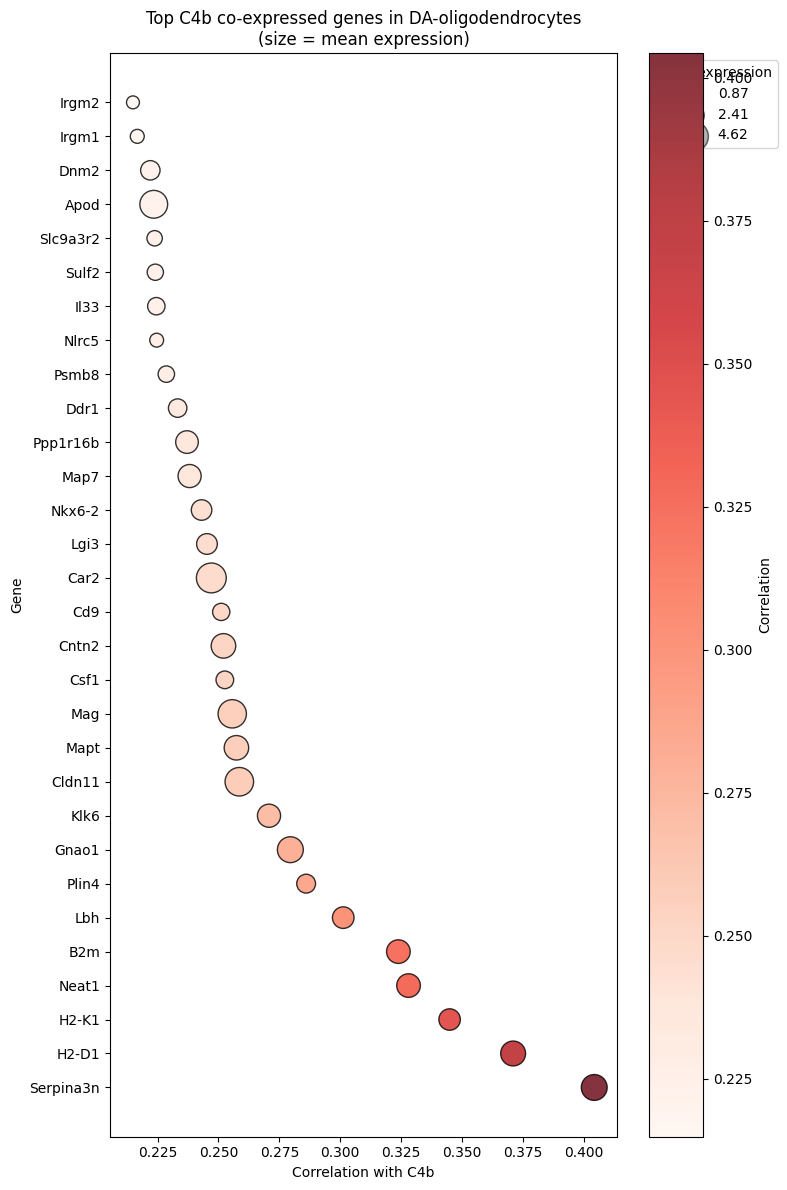

In [154]:
import matplotlib.pyplot as plt

def dotplot_corr_expr(results, top_n=30):
    """
    Dotplot of genes ranked by correlation with C4b.
    Dot size = mean expression, Dot color = correlation with C4b.
    """
    df = results.sort_values("corr_with_C4b", ascending=False).head(top_n)

    plt.figure(figsize=(8, 0.4*top_n))
    sc = plt.scatter(
        x=df["corr_with_C4b"],
        y=df["gene"],
        s=df["mean_expression"]*100,   # scale size by mean expression
        c=df["corr_with_C4b"],
        cmap="Reds",
        alpha=0.8,
        edgecolor="k"
    )

    plt.xlabel("Correlation with C4b")
    plt.ylabel("Gene")
    plt.colorbar(sc, label="Correlation")
    plt.title("Top C4b co-expressed genes in DA-oligodendrocytes\n(size = mean expression)")

    # --- add size legend, positioned outside ---
    sizes = [df["mean_expression"].min(), df["mean_expression"].median(), df["mean_expression"].max()]
    labels = [f"{s:.2f}" for s in sizes]
    handles = [plt.scatter([], [], s=s*100, color="gray", alpha=0.6, edgecolor="k") for s in sizes]

    plt.legend(
        handles, labels, title="Mean expression",
        bbox_to_anchor=(1.05, 1), loc="upper left", frameon=True
    )

    plt.tight_layout()
    plt.show()

# usage
dotplot_corr_expr(top_genes, top_n=30)

### Patterns in the C4b+ DA-oligo coexpression module
1.	Core immune cluster: *Serpina3n, H2-D1, H2-K1, B2m, Psmb8, Nlrc5, Irgm1*
→ tightly co-expressed, suggesting a strong MHC-I/IFN/innate immunity axis.

2.	Stress/metabolic cluster: *Neat1, Lbh, Plin4, Apod, Sulf2, Slc9a3r2*
→ long noncoding RNA + lipid droplet + oxidative/lipid metabolism → stress/lipid response signature.
3.	OL/myelin/cytoskeletal identity cluster: *Cldn11, Mag, Nkx6-2, Cntn2, Car2, Map7, Mapt, Cd9*
→ myelin structure, cytoskeleton stabilization, OL lineage identity → confirms these are still OLs.
4.	Signaling/adhesion cluster: *Gnao1, Dnm2, Ddr1, Lgi3, Ppp1r16b*
→ suggests cell–cell communication and vesicle/ECM interactions as part of this program.

# Regression-based approach

In [151]:
from sklearn.linear_model import LassoCV

X = da_oligos.to_df().drop(columns=["C4b"])
y = da_oligos.to_df()["C4b"]

lasso = LassoCV(cv=5).fit(X, y)
coefs = pd.Series(lasso.coef_, index=X.columns)
coefs = coefs[coefs != 0].sort_values(ascending=False)
print(coefs.head(20))

Serpina3n    0.130291
Gfap         0.125980
H2-D1        0.084752
B2m          0.066932
Neat1        0.065639
Klk6         0.059543
H2-K1        0.048684
App          0.046730
Car2         0.045213
Plin4        0.043022
C3           0.036783
Gnao1        0.034219
Mag          0.033679
Lbh          0.031679
Cd9          0.031260
Abca8a       0.030386
Mapt         0.029946
Stmn4        0.029399
Nlrc5        0.028467
Stat3        0.026532
dtype: float32


## Key takeaways from your list

### What it does 	
- Each number is the regression coefficient: how much that gene contributes to predicting C4b levels when all the other genes are in the model.
- Unlike correlation (pairwise, linear only), this is a multivariate model → it accounts for redundancy between genes.
- So genes with non-zero weights are those that uniquely help explain variance in C4b expression.
### Interpretation 
- Serpina3n, Gfap, H2-D1, B2m, H2-K1 → strong immune/stress axis, MHC-I pathway, consistent with your correlation analysis.
- Neat1, Klk6, Plin4 → metabolic/stress genes also contribute.
- App, Mapt, Mag, Cd9, Car2, Abca8a → myelin/OL structure + Alzheimer-related (App, Mapt). Suggests C4b+ DA-oligos are in a degenerative/stressed OL state.
- C3, Stat3 → complement amplification + transcriptional regulation.
- Stmn4 → cytoskeletal remodeling.

# Clustering of C4b+ cells

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


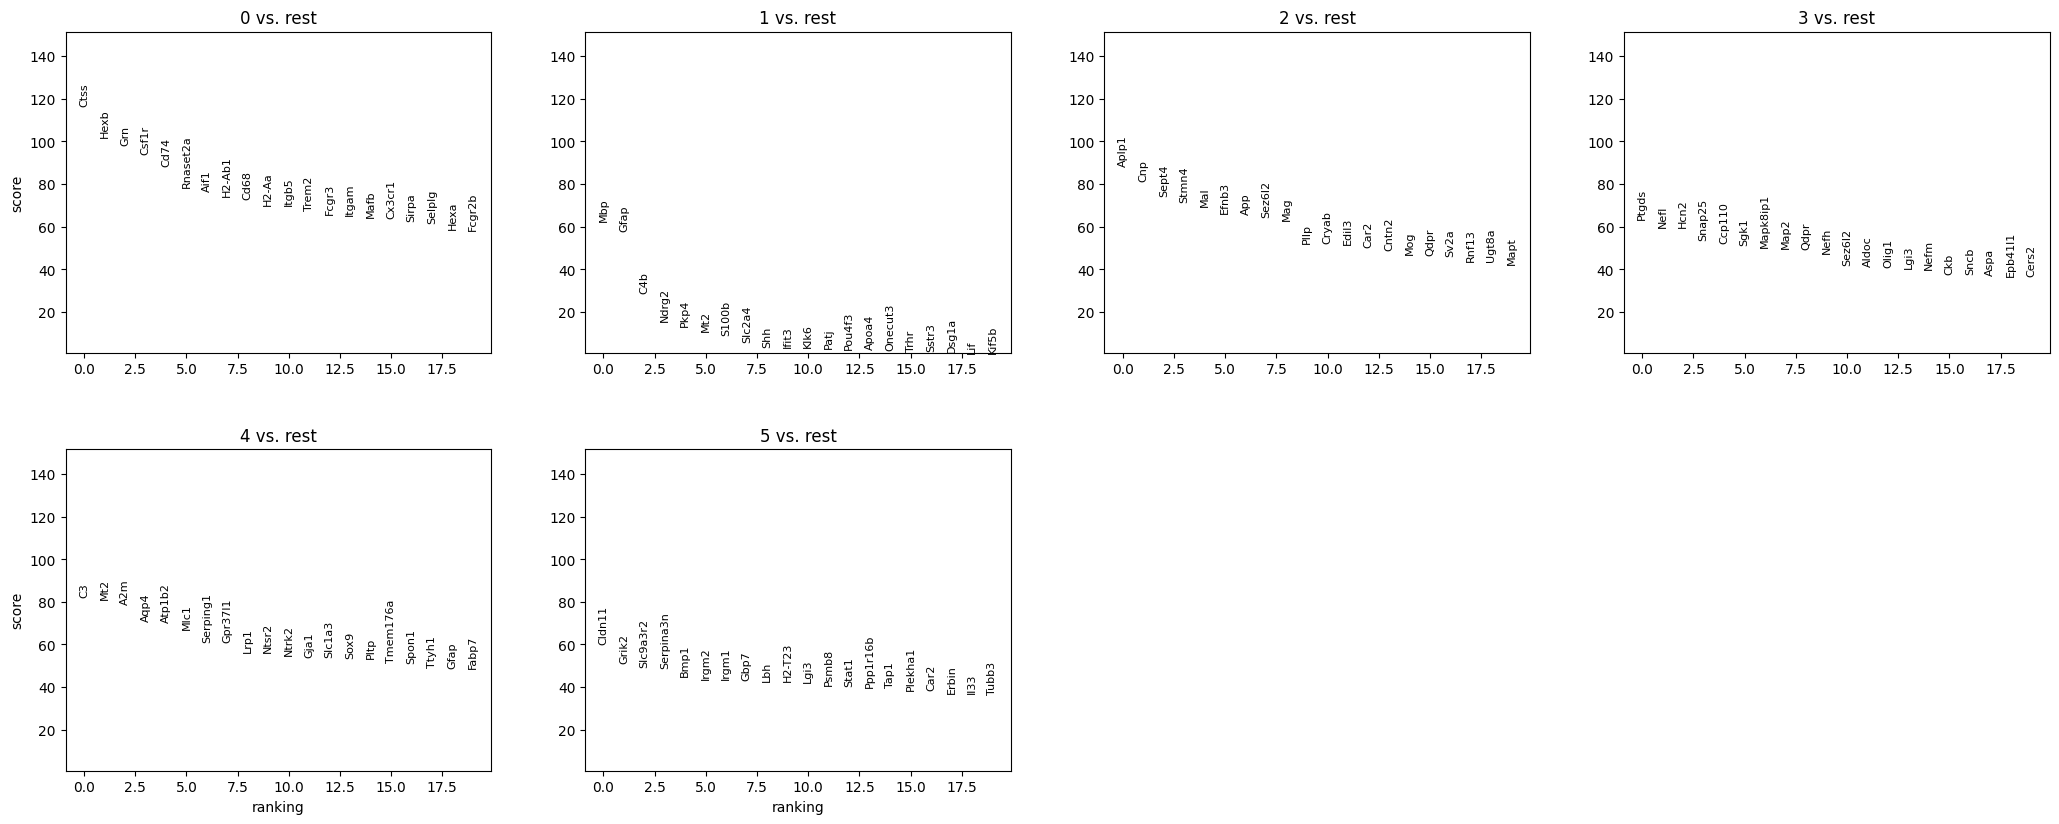

In [157]:
import scanpy as sc

adata_sub = da_oligos[da_oligos[:, "C4b"].X.A.ravel() > 0, :]
sc.pp.pca(adata_sub)
sc.pp.neighbors(adata_sub)
sc.tl.leiden(adata_sub, resolution=0.5)
sc.tl.rank_genes_groups(adata_sub, "leiden", method="wilcoxon")
sc.pl.rank_genes_groups(adata_sub)

# Mutual information (nonlinear associations)

In [152]:
from sklearn.feature_selection import mutual_info_regression

X = da_oligos.to_df().drop(columns=["C4b"])
y = da_oligos.to_df()["C4b"]

mi = mutual_info_regression(X, y)
mi_scores = pd.Series(mi, index=X.columns).sort_values(ascending=False)
print(mi_scores.head(20))

Rab7        1.824038
Kif1b       1.801191
Kcnj10      1.798117
Ywhae       1.761181
Sv2a        1.751181
Mapk8ip1    1.728400
Cd81        1.725689
Lamp1       1.725000
Agpat4      1.723337
Rac1        1.715709
Nkx6-2      1.702716
Aldoa       1.702586
Edil3       1.698989
Sept8       1.693762
Scarb2      1.692825
Cntn2       1.683732
Dnm2        1.681234
Dst         1.676120
Map7        1.676054
Rtn3        1.673819
dtype: float64


## Interpretation
- Rab7, Lamp1, Aldoa, Dst, Map7 → trafficking & cytoskeleton. Suggests C4b+ DA-oligos may have endo/lysosomal stress and cytoskeletal remodeling.
- Kif1b, Kcnj10, Sv2a → axon/myelin integrity and neuronal signaling. That’s striking because C4b is an OL signal, but it seems tied to pathways usually linked to axon–glia communication.
- Cd81, Agpat4, ScarB2 → lipid handling & membrane biology (fits with complement & myelin remodeling).
- Nkx6-2 → OL lineage TF — confirms OL identity of the C4b+ cells.
- Ywhae, Mapk8ip1 → stress / signaling scaffolds.


#  Cell-level co-expression probability

In [153]:
X = da_oligos.to_df()
c4b_pos = X["C4b"] > 0

coexpr_fraction = (X.loc[c4b_pos] > 0).mean()
coexpr_fraction = coexpr_fraction.sort_values(ascending=False).head(20)

In [155]:
coexpr_fraction

C4b          1.000000
Mbp          0.996411
Aplp1        0.988018
Cnp          0.971787
Gfap         0.965611
Mag          0.959831
Car2         0.959435
Cldn11       0.944682
Ermn         0.943758
App          0.940908
Stmn4        0.927131
Apod         0.920903
Gnao1        0.920823
Sept4        0.913513
Mal          0.901584
Lamp1        0.883478
Cryab        0.879625
Cntn2        0.878833
Mapt         0.875323
Serpina3n    0.867168
dtype: float64

## Interpretation
- Core OL identity genes dominate (Mbp, Cnp, Mag, Cldn11, Car2, Aplp1). → confirms C4b+ cells are bona fide oligodendrocytes.
- Stress/degeneration genes: Gfap, App, Stmn4, Cryab, Mapt. → suggests C4b+ DA-oligos are in a degenerative/reactive state.
- Immune/metabolic genes: Serpina3n, Lamp1, Apod, Gnao1.→ ties into the complement/immune axis.


# All together
- Correlation gave you a classic immune signature (Serpina3n, H2-D1, B2m).
- Lasso added structural and degenerative players (App, Mapt, Mag, Stat3).
- MI now highlights trafficking, metabolism, and axon–glia communication genes — things that correlation would miss because their relationship to C4b might only show up in certain subsets or thresholds.

Together, these three approaches triangulate C4b biology:
- **Correlation** → Immune complement / MHC (correlation).
- **Lasso** → Degeneration + stress (Lasso).
- **Mutual Information** → Trafficking + metabolism + axon–glia crosstalk (MI).
- **Co-expression probability** → OL identity + stress markers that are almost always on in C4b+ cells.

This makes sense:
- Correlation finds gradients.
- Lasso finds unique predictors.
- MI finds nonlinear associations.
- Co-expression finds hard co-activation rules.